In [9]:
import pandas as pd
import numpy as np
import warnings
import ast
import re
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [22]:
full_df = pd.read_csv('d:\WorkLab\RecSystem\data\df_with_clusters.csv', sep=',', quotechar='"')
rating_full_df = pd.read_csv(r'd:\WorkLab\RecSystem\data\ratings.csv')
movies_df = pd.read_csv('D:\WorkLab\RecSystem\data\movies.csv')

In [18]:
movies_df.drop_duplicates('title')

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [ ]:
full_df['embedding'] = full_df['embedding'].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))


In [23]:
full_df

,movieId,title,genres,embedding,cluster,pca1,pca2
0,1,Toy Story (1995),"['Adventure', 'Animation', 'Children', 'Comedy...","[-0.0466427206993103, 0.025392401963472366, 0....",69,0.062858,0.019720
1,2,Jumanji (1995),"['Adventure', 'Children', 'Fantasy']","[-0.0466427206993103, 0.025392401963472366, 0....",18,0.078340,0.029752
2,3,Grumpier Old Men (1995),"['Comedy', 'Romance']","[-0.0197464469820261, -0.04607229307293892, -0...",12,0.065540,0.011116
3,4,Waiting to Exhale (1995),"['Comedy', 'Drama', 'Romance']","[-0.0197464469820261, -0.04607229307293892, -0...",4,0.094119,0.045840
4,5,Father of the Bride Part II (1995),['Comedy'],"[-0.0197464469820261, -0.04607229307293892, -0...",6,0.012554,0.016579
...,...,...,...,...,...,...,...
62418,209157,We (2018),['Drama'],"[0.0036846771836280823, -0.0424957275390625, 0...",10,-0.028999,-0.057013
62419,209159,Window of the Soul (2001),['Documentary'],"[0.04912317916750908, -0.0037118904292583466, ...",2,-0.061628,0.064973
62420,209163,Bad Poems (2018),"['Comedy', 'Drama']","[-0.0197464469820261, -0.04607229307293892, -0...",8,0.064795,0.037002
62421,209169,A Girl Thing (2001),['(no genres listed)'],"[0.007933378219604492, 0.00995192676782608, 0....",14,-0.070053,-0.018345


In [24]:
rating_df = rating_full_df[:1000000]

In [25]:
datetimes = pd.to_datetime(rating_df['timestamp'], unit='s') 
rating_df['month'] = datetimes.dt.month
rating_df['day'] = datetimes.dt.day
rating_df['day_of_week'] = datetimes.dt.day_of_week
rating_df['hour'] = datetimes.dt.hour

def get_part_of_day(hour):
    if 5 <= hour < 12:
        return 1
    elif 12 <= hour < 17:
        return 2
    elif 17 <= hour < 21:
        return 3
    else:
        return 4
    
rating_df['part_of_day'] = rating_df['hour'].apply(get_part_of_day)
rating_df.drop('timestamp', axis=1, inplace=True)

In [26]:
df = rating_df.merge(full_df, how='inner', on='movieId')
df.drop(axis=1, columns=['pca1', 'pca2'] ,inplace=True)

In [27]:
df_mean_cluster = df.groupby(by='cluster')['rating'].mean()
mean_movie_ratings = rating_full_df.groupby('movieId')['rating'].mean()
movie_rating_count = df.groupby('movieId')['rating'].count()
mean_user_ratings = df.groupby('userId')['rating'].mean()

In [28]:
full_df = df.merge(df_mean_cluster, on='cluster', suffixes=['_user', '_mean_cluster'])\
.merge(mean_movie_ratings, on='movieId', suffixes=['_mean_movie', '_mean_movie'])\
.merge(movie_rating_count, on='movieId', suffixes=['', '_movie_count'])\
.merge(mean_user_ratings, on='userId', suffixes=['','_mean_user'])

In [29]:
full_df['diff_mean_ratings'] = full_df['rating_user'] - full_df['rating_mean_user']

In [30]:
full_df.rename(columns={'rating' : "rating_mean_movie"}, inplace=True)

In [34]:
full_df

,userId,movieId,rating_user,month,day,day_of_week,hour,part_of_day,title,genres,embedding,cluster,rating_mean_cluster,rating_mean_movie,rating_movie_count,rating_mean_user,diff_mean_ratings
0,1,296,5.0,5,17,2,15,2,Pulp Fiction (1994),"['Comedy', 'Crime', 'Drama', 'Thriller']","[-0.01974645, -0.04607229, -0.0348254, -0.0465...",31,3.790966,4.188912,3275,3.814286,1.185714
1,1,306,3.5,5,17,2,12,2,Three Colors: Red (Trois couleurs: Rouge) (1994),['Drama'],"[0.00368468, -0.04249573, 0.02030548, -0.01552...",13,3.715849,4.072967,297,3.814286,-0.314286
2,1,307,5.0,5,17,2,12,2,Three Colors: Blue (Trois couleurs: Bleu) (1993),['Drama'],"[0.00368468, -0.04249573, 0.02030548, -0.01552...",13,3.715849,3.981409,246,3.814286,1.185714
3,1,665,5.0,5,17,2,15,2,Underground (1995),"['Comedy', 'Drama', 'War']","[-0.01974645, -0.04607229, -0.0348254, -0.0465...",16,3.657749,3.946020,58,3.814286,1.185714
4,1,899,3.5,5,17,2,12,2,Singin' in the Rain (1952),"['Comedy', 'Musical', 'Romance']","[-0.01974645, -0.04607229, -0.0348254, -0.0465...",22,3.542217,4.050987,423,3.814286,-0.314286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,6747,3566,2.0,12,17,0,5,1,"Big Kahuna, The (2000)","['Comedy', 'Drama']","[-0.01974645, -0.04607229, -0.0348254, -0.0465...",5,3.601395,3.289493,56,2.886218,-0.886218
999996,6747,3578,5.0,8,22,2,13,2,Gladiator (2000),"['Action', 'Adventure', 'Drama']","[-0.0192516, -0.03248253, 0.03083933, -0.02896...",17,3.484657,3.951473,1774,2.886218,2.113782
999997,6747,3593,2.0,8,16,3,21,4,Battlefield Earth (2000),"['Action', 'Sci-Fi']","[-0.0192516, -0.03248253, 0.03083933, -0.02896...",35,3.458335,1.578374,165,2.886218,-0.886218
999998,6747,3615,4.0,8,23,3,18,3,Dinosaur (2000),"['Adventure', 'Animation', 'Children']","[-0.04664272, 0.0253924, 0.00217844, -0.027348...",19,3.319508,3.045339,123,2.886218,1.113782


In [31]:
full_df.loc[:, ['userId','movieId', 'rating_user', 'title','genres', 'rating_movie_count', 'rating_mean_movie']]

,userId,movieId,rating_user,title,genres,rating_movie_count,rating_mean_movie
0,1,296,5.0,Pulp Fiction (1994),"['Comedy', 'Crime', 'Drama', 'Thriller']",3275,4.188912
1,1,306,3.5,Three Colors: Red (Trois couleurs: Rouge) (1994),['Drama'],297,4.072967
2,1,307,5.0,Three Colors: Blue (Trois couleurs: Bleu) (1993),['Drama'],246,3.981409
3,1,665,5.0,Underground (1995),"['Comedy', 'Drama', 'War']",58,3.946020
4,1,899,3.5,Singin' in the Rain (1952),"['Comedy', 'Musical', 'Romance']",423,4.050987
...,...,...,...,...,...,...,...
999995,6747,3566,2.0,"Big Kahuna, The (2000)","['Comedy', 'Drama']",56,3.289493
999996,6747,3578,5.0,Gladiator (2000),"['Action', 'Adventure', 'Drama']",1774,3.951473
999997,6747,3593,2.0,Battlefield Earth (2000),"['Action', 'Sci-Fi']",165,1.578374
999998,6747,3615,4.0,Dinosaur (2000),"['Adventure', 'Animation', 'Children']",123,3.045339


In [32]:
genres_list = movies_df['genres'].apply(lambda x: x.split('|'))
genres_list

0        [Adventure, Animation, Children, Comedy, Fantasy]
1                           [Adventure, Children, Fantasy]
2                                        [Comedy, Romance]
3                                 [Comedy, Drama, Romance]
4                                                 [Comedy]
                               ...                        
62418                                              [Drama]
62419                                        [Documentary]
62420                                      [Comedy, Drama]
62421                                 [(no genres listed)]
62422                           [Action, Adventure, Drama]
Name: genres, Length: 62423, dtype: object

In [33]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(genres_list)
labels = list(mlb.classes_)
mlb.transform(genres_list)

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])

In [34]:
print(labels)

['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [35]:
genre_encoded = pd.DataFrame(mlb.transform(genres_list), columns=mlb.classes_, index=movies_df.index)
movie_encoded = pd.concat([movies_df.drop('genres', axis=1), genre_encoded], axis=1)
test_df = full_df.merge(movie_encoded.drop('title', axis=1), on='movieId', how='inner')

In [71]:
print(genre_encoded)

       (no genres listed)  Action  Adventure  Animation  Children  Comedy  \
0                       0       0          1          1         1       1   
1                       0       0          1          0         1       0   
2                       0       0          0          0         0       1   
3                       0       0          0          0         0       1   
4                       0       0          0          0         0       1   
...                   ...     ...        ...        ...       ...     ...   
62418                   0       0          0          0         0       0   
62419                   0       0          0          0         0       0   
62420                   0       0          0          0         0       1   
62421                   1       0          0          0         0       0   
62422                   0       1          1          0         0       0   

       Crime  Documentary  Drama  Fantasy  Film-Noir  Horror  IMAX  Musical

In [36]:
mean_genres_by_users = pd.concat(
    [
        test_df['userId'],
        test_df[list(mlb.classes_)].multiply(test_df['rating_user'], axis=0)
    ], axis=1
).groupby('userId').mean()
mean_genres_by_users

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.235714,0.585714,0.114286,0.164286,1.271429,0.464286,0.028571,2.928571,0.257143,0.050000,0.050000,0.000000,0.264286,0.200000,1.071429,0.264286,0.307143,0.278571,0.035714
2,0.000000,1.326087,1.592391,0.334239,0.497283,1.135870,0.307065,0.000000,1.766304,0.627717,0.000000,0.065217,0.154891,0.195652,0.160326,0.584239,0.611413,0.625000,0.279891,0.067935
3,0.005335,1.853659,1.113567,0.303354,0.271341,0.926829,0.782012,0.014482,1.375762,0.444360,0.032774,0.243140,0.461128,0.032774,0.355945,0.323171,1.262195,1.345274,0.146341,0.045732
4,0.000000,1.909091,1.448347,0.444215,0.371901,1.208678,0.607438,0.084711,0.758264,0.456612,0.000000,0.130165,0.411157,0.105372,0.283058,0.142562,1.111570,0.820248,0.123967,0.105372
5,0.000000,0.663366,0.801980,0.148515,0.297030,1.732673,0.574257,0.000000,1.702970,0.277228,0.000000,0.138614,0.118812,0.257426,0.326733,0.702970,0.445545,0.950495,0.089109,0.148515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6743,0.000000,0.723270,1.044025,0.968553,0.742138,1.459119,0.336478,0.000000,2.207547,0.628931,0.000000,0.138365,0.226415,0.213836,0.232704,1.097484,0.672956,0.534591,0.169811,0.025157
6744,0.000000,1.410000,0.610000,0.080000,0.180000,0.540000,0.740000,0.000000,1.450000,0.210000,0.030000,0.260000,0.000000,0.000000,0.350000,0.200000,0.600000,1.040000,0.410000,0.210000
6745,0.000000,1.632850,1.062802,0.135266,0.260870,0.946860,0.850242,0.024155,1.265700,0.294686,0.082126,0.231884,0.000000,0.048309,0.613527,0.487923,0.956522,1.966184,0.067633,0.057971


In [37]:
full_df= test_df.merge(mean_genres_by_users, how='left', on='userId', suffixes=('', '_mean_gen'))

In [41]:
full_df

,userId,movieId,rating_user,month,day,day_of_week,hour,part_of_day,title,genres,...,Film-Noir_mean_gen,Horror_mean_gen,IMAX_mean_gen,Musical_mean_gen,Mystery_mean_gen,Romance_mean_gen,Sci-Fi_mean_gen,Thriller_mean_gen,War_mean_gen,Western_mean_gen
0,1,296,5.0,5,17,2,15,2,Pulp Fiction (1994),"['Comedy', 'Crime', 'Drama', 'Thriller']",...,0.050000,0.050000,0.000000,0.264286,0.200000,1.071429,0.264286,0.307143,0.278571,0.035714
1,1,306,3.5,5,17,2,12,2,Three Colors: Red (Trois couleurs: Rouge) (1994),['Drama'],...,0.050000,0.050000,0.000000,0.264286,0.200000,1.071429,0.264286,0.307143,0.278571,0.035714
2,1,307,5.0,5,17,2,12,2,Three Colors: Blue (Trois couleurs: Bleu) (1993),['Drama'],...,0.050000,0.050000,0.000000,0.264286,0.200000,1.071429,0.264286,0.307143,0.278571,0.035714
3,1,665,5.0,5,17,2,15,2,Underground (1995),"['Comedy', 'Drama', 'War']",...,0.050000,0.050000,0.000000,0.264286,0.200000,1.071429,0.264286,0.307143,0.278571,0.035714
4,1,899,3.5,5,17,2,12,2,Singin' in the Rain (1952),"['Comedy', 'Musical', 'Romance']",...,0.050000,0.050000,0.000000,0.264286,0.200000,1.071429,0.264286,0.307143,0.278571,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,6747,3566,2.0,12,17,0,5,1,"Big Kahuna, The (2000)","['Comedy', 'Drama']",...,0.027244,0.253205,0.025641,0.150641,0.222756,0.578526,0.426282,0.772436,0.118590,0.075321
999996,6747,3578,5.0,8,22,2,13,2,Gladiator (2000),"['Action', 'Adventure', 'Drama']",...,0.027244,0.253205,0.025641,0.150641,0.222756,0.578526,0.426282,0.772436,0.118590,0.075321
999997,6747,3593,2.0,8,16,3,21,4,Battlefield Earth (2000),"['Action', 'Sci-Fi']",...,0.027244,0.253205,0.025641,0.150641,0.222756,0.578526,0.426282,0.772436,0.118590,0.075321
999998,6747,3615,4.0,8,23,3,18,3,Dinosaur (2000),"['Adventure', 'Animation', 'Children']",...,0.027244,0.253205,0.025641,0.150641,0.222756,0.578526,0.426282,0.772436,0.118590,0.075321


In [38]:
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(['rating_user', 'title', 'embedding', 'genres', 'rating_mean_user'], axis=1), full_df['rating_user'], test_size=0.2, random_state=42)

In [43]:
X_test.columns

Index(['userId', 'movieId', 'month', 'day', 'day_of_week', 'hour',
       'part_of_day', 'cluster', 'rating_mean_cluster', 'rating_mean_movie',
       'rating_movie_count', 'diff_mean_ratings', '(no genres listed)',
       'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
       '(no genres listed)_mean_gen', 'Action_mean_gen', 'Adventure_mean_gen',
       'Animation_mean_gen', 'Children_mean_gen', 'Comedy_mean_gen',
       'Crime_mean_gen', 'Documentary_mean_gen', 'Drama_mean_gen',
       'Fantasy_mean_gen', 'Film-Noir_mean_gen', 'Horror_mean_gen',
       'IMAX_mean_gen', 'Musical_mean_gen', 'Mystery_mean_gen',
       'Romance_mean_gen', 'Sci-Fi_mean_gen', 'Thriller_mean_gen',
       'War_mean_gen', 'Western_mean_gen'],
      dtype='object')

In [39]:
def evalute_model(predict, y_test):
    metrics ={
        'MSE': mean_squared_error(predict, y_test),
        'MAE': mean_absolute_error(predict, y_test),
        'MAPE': mean_absolute_percentage_error(predict, y_test) * 100,
        'R2': r2_score(y_test, predict)
    }

    results_df = pd.DataFrame(metrics.items(), columns=['Metric_linear_regression', 'Value_linear_regression'])
    print(results_df.to_string(index=False, float_format='%.4f'))
    

In [45]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
predict = linear_model.predict(X_test)

evalute_model(predict, y_test)


Metric_linear_regression  Value_linear_regression
                     MSE                   0.0154
                     MAE                   0.0903
                    MAPE                   3.0217
                      R2                   0.9861


In [46]:
evalute_model(predict, y_test)


Metric_linear_regression  Value_linear_regression
                     MSE                   0.0154
                     MAE                   0.0903
                    MAPE                   3.0217
                      R2                   0.9861


In [40]:
from xgboost import XGBRegressor

from sklearn.model_selection import RandomizedSearchCV

xgb_model = XGBRegressor()
param_grid = {
    'max_depth' : [7,9,10],
    'gamma' : [0.1, 0.15, 0.3],
    'alpha' : [0.1, 0.15, 0.3],
    'reg_lambda' : [1.5, 2, 2.5],
    'learning_rate' : [0.02, 0.05, 0.1],
    'n_estimators': [200, 300, 400] 
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions = param_grid,
    n_iter=5,
    cv = 5,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
best_model = random_search.best_estimator_
xpredict = best_model.predict(X_test)



In [42]:
from xgboost import Booster
best_model.save_model('xgb_model_predict.pkl')

In [41]:
evalute_model(xpredict, y_test)


Metric_linear_regression  Value_linear_regression
                     MSE                   0.0024
                     MAE                   0.0314
                    MAPE                   1.1441
                      R2                   0.9978


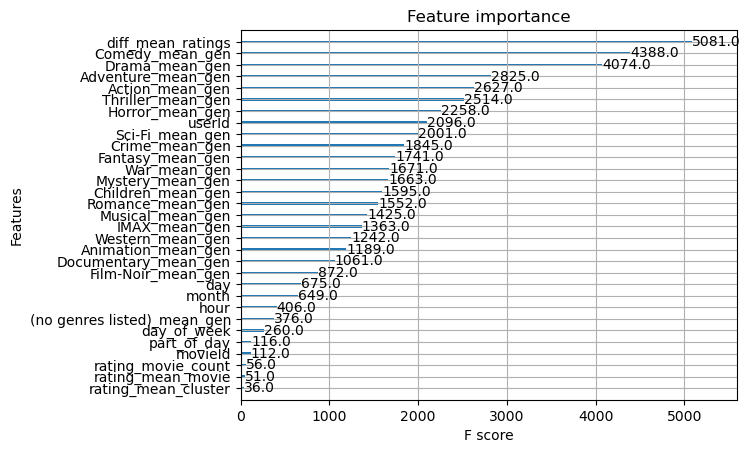

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(best_model, max_num_features=31)
plt.show()

In [ ]:
import joblib
joblib.dump(best_model, 'xgb_movie_rating_predictor.pkl')

['xgb_movie_rating_predictor.pkl']

In [ ]:
td = pd.concat([X_test, pd.Series(xpredict)], axis=1)

In [ ]:
td

,userId,movieId,month,day,day_of_week,hour,part_of_day,cluster,rating_mean_cluster,rating_mean_movie,...,Horror_mean_gen,IMAX_mean_gen,Musical_mean_gen,Mystery_mean_gen,Romance_mean_gen,Sci-Fi_mean_gen,Thriller_mean_gen,War_mean_gen,Western_mean_gen,0
987231,6633.0,91500.0,1.0,25.0,4.0,1.0,4.0,17.0,3.484657,3.518994,...,0.014778,0.403941,0.354680,0.221675,1.354680,0.583744,0.581281,0.120690,0.014778,NaN
79954,610.0,3273.0,5.0,27.0,2.0,0.0,4.0,25.0,3.166970,2.430953,...,0.186528,0.137306,0.049223,0.308290,0.331606,0.702073,0.904145,0.321244,0.080311,3.954043
567130,3867.0,762.0,7.0,5.0,5.0,11.0,1.0,38.0,3.500082,2.403896,...,0.080000,0.000000,0.280000,0.060000,0.520000,0.800000,1.340000,0.000000,0.000000,NaN
500891,3446.0,1485.0,4.0,7.0,6.0,2.0,4.0,14.0,3.237975,3.238084,...,0.388664,0.006748,0.098516,0.155196,0.553306,0.334683,0.493927,0.199730,0.048583,NaN
55399,442.0,7360.0,3.0,24.0,3.0,0.0,4.0,32.0,3.567703,3.572959,...,0.515306,0.040816,0.244898,0.290816,0.438776,0.795918,1.045918,0.107143,0.035714,3.066425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.013432
199994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.956168
199995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.027312
199997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.472945


In [ ]:
pred =  pd.Series(xpredict)

In [ ]:
dd = X_test.merge(pred.to_frame(), left_index=True, right_index=True)

In [ ]:
dd.rename(columns={0: "predict"} , inplace=True)

In [ ]:
dd.groupby(['userId', 'cluster'])['predict'].mean()

userId  cluster
1       0          4.032271
        3          2.913698
        5          2.969266
        10         3.986700
        13         2.993748
                     ...   
1409    33         4.201233
        35         3.993312
        36         3.521265
        38         3.902172
        39         4.985250
Name: predict, Length: 17431, dtype: float32

In [ ]:
dd.iloc[:,:12]

,userId,movieId,month,day,day_of_week,hour,part_of_day,cluster,rating_mean_cluster,rating_mean_movie,rating_movie_count,diff_mean_ratings
79954,610,3273,5,27,2,0,4,25,3.166970,2.430953,279,-1.707254
55399,442,7360,3,24,3,0,4,32,3.567703,3.572959,214,1.066327
135049,958,112,11,4,0,17,3,19,3.319508,3.406233,466,-0.634831
51333,418,671,3,10,3,0,4,7,3.322388,3.674146,228,-0.904930
35032,273,8228,10,23,4,1,4,1,3.533953,4.009770,135,0.676471
...,...,...,...,...,...,...,...,...,...,...,...,...
125423,901,1729,4,27,3,6,1,4,3.864656,3.695320,475,0.621368
54807,440,2139,1,9,4,4,4,8,3.600543,3.727479,189,0.525862
18104,148,1207,2,8,0,14,2,13,3.715849,4.146441,660,-0.128788
128741,917,1290,11,16,1,12,2,0,3.747057,3.543178,111,1.696035
